# [PH481] Assignment 5.5


In class, we explored how the relativistic motion of a charged particle in a magnetic field produces radiation, with its emission highly beamed in the forward direction (synchrotron radiation).

(1) Time dependence of the electric field: Derive the time-dependent electric field generated by the moving charge as a function of its speed (𝛾), the magnetic field (𝐵), and the pitch angle (𝜑).

(2) Fourier transform and synchrotron spectrum: Perform a Fourier transform of the electric field to compute the synchrotron radiation spectrum of a single electron. You may use a programming language of your choice for numerical calculations, if needed.

(3) Spectrum analysis and visualization: Plot the resulting spectrum of (2), experimenting with both linear and logarithmic scales for the 𝑥 and 𝑦 axes. Discuss the key features of the spectrum, focusing on how the peak frequency varies and its relationship to the synchrotron frequency defined during class.

References for Assistance:
* Radiative Processes in Astrophysics by Rybicki & Lightman (Chapter 6)
* Essential Radio Astronomy by Condon & Ransom (Chapter 51)

<br/>

***

(1) We already have calculated the form of electric field as a function of time. (Please refer to the submitted document)

$$ E(t) = \frac{q^2 \beta}{4 \pi \epsilon_0 \gamma^2 m_e c} \frac{B}{R} \left[ \frac{\beta - \cos{\omega_{c}t}}{(1 - \beta \cos{\omega_{c} t})^3 } \right], $$

where $\omega_{c}$ is synchrotron frequency,

$$ \omega_{c} \equiv \gamma^2 \frac{q B}{m_e} \sin \varphi.$$

Now let's further work on (2) and (3).

<br/>

## 1. Packages \& Constants

Below is the packages and default setting to get a plot. <br/>
Of course, you can modify the fonts.

### 1) Packages

In [1]:
import numpy as np                              # basic
   
import matplotlib.pyplot as plt                 # plot
import matplotlib.ticker as ticker              # set ticker range
from matplotlib.patches import Rectangle        # add rectangular mark on the figure
# from matplotlib.mlab import psd

import scipy.constants as Const                 # constants

import sys                                      # To get bash variable in python
import os                                       # To get bash variable in python
from copy import copy, deepcopy                 # To copy the class


## To enable the interactive widgets (such as plots).
%matplotlib widget

## To print all the out put without truncating.
np.set_printoptions(threshold=sys.maxsize)


### 2) Constants

In [2]:
print(Const.c)
print(Const.e)
print(Const.m_e)

299792458.0
1.602176634e-19
9.1093837015e-31


<br/>

## 2. Attributes for Electric field & PSD data

We will going to define a class attribute for Lightcurve & PSD. <br/>
Class is an object that provides data(attributes) and functions. If you are new to Class type, refer below:
* Official python documents https://docs.python.org/3/tutorial/classes.html
* Simple examples with results https://www.w3schools.com/python/python_classes.asp

Also, it is convenient to use `.fits`(=`.lc`) file. About the fits file handling in `astropy`, refer below:
* `astropy` fits file handling; https://docs.astropy.org/en/latest/io/fits/index.html
* `astropy` fits header; https://docs.astropy.org/en/latest/io/fits/usage/headers.html
* `astropy` table data; https://docs.astropy.org/en/latest/io/fits/usage/table.html

<br/>

### 1) Define `Edata` class attribute

In [3]:
class Edata :
    def __init__(self, binsize, beta, B_field, pitch_angle, time_duration) :
        self.binsize = binsize                                              # binsize of time interval (to plot)
        self.time_sec = np.arange(0, time_duration, self.binsize)           # time range to plot
        self.coefficient = 1                                                # plot up to coefficient
        self.beta = beta                                                    # speed of particle, i.e. v/c
        self.gamma = 1 / np.sqrt(1 - self.beta**2)                          # Lorentz factor
        self.pitch_angle = pitch_angle                                      # pitch angle, angle between observer and radiation
        self.B_field = B_field                                              # magnetic field
        self.omega_B = np.sin(self.pitch_angle) * Const.e * self.B_field / (Const.m_e * Const.c)       # cyclotron frequency
        self.omega_c = self.gamma**2 * self.omega_B                         # synchrotron frequency
        self.distance = 1                                                   # distance between observer and the source
        self.pulse_duration = 2 * np.pi / self.omega_c                      # synchrotron pulse duration

        coefficient = -Const.e**2 * self.beta * self.B_field / (4 * np.pi * Const.epsilon_0 * self.gamma**2 * Const.m_e * Const.c * self.distance) 
        self.count_rate = coefficient * (self.beta - np.cos(self.omega_c * self.time_sec)) / (1 - self.beta * np.cos(self.omega_c * self.time_sec))**3
        print("Cyclotron frequency: {:.2e}, Synchrotron frequency: {:.2e}".format(self.omega_B, self.omega_c))
        print("Cyclotron orbit period: {:.2f} s, Synchrotron pulse duration: {:.2f} s".format(2 * np.pi / self.omega_B, self.pulse_duration))


    # Class attribute cannot be copied without corrupting the original data. We need a function for it.
    def __copy__(self) :
        # return LCdata(self.input_pwd)
        new_LCdata = type(self).__new__(self.__class__)
        new_LCdata.__dict__.update(self.__dict__)
        return new_LCdata


    # To cut a data and make a Echunk data.
    def cut_fits(self, i, j) :
        self.time_sec = self.time_sec[i:j]
        self.count_rate = self.count_rate[i:j]

        return self


<br/><br/>

### 2) Define `PSDdata` class attribute

| Discrete Fourier Transform |<sup>2</sup>



The absolute value of discrete Fourier transform function is:
$$ |DFT(f_j)|^2 = \bigg|\sum_{i=0}^{N-1} x_i e^{-2\pi i f_j t_i} \bigg|^2 = \left[ \sum_{i=0}^{N-1} x_i \cos(2\pi f_j t_i)  \right]^2 + \left[ \sum_{i=0}^{N-1} x_i \sin(2\pi f_j t_i)  \right]^2 . $$ 
$$ t_i = n \Delta t \quad\quad f_j = \frac{k}{N \Delta t},  \quad\quad  (n = 0, 1, 2, \cdots, N-1, k = 0, 1, 2, \cdots, \frac{N-1}{2})$$
where $\Delta t$ is a time binning. The normalization factor is
<!-- Thus,  -->
<!-- $$ |DFT(f)|^2 = \left[ \sum_{k=0}^{N-1}\sum_{n=0}^{N-1} x_i \cos \left( 2\pi \frac{k}{N}n \right)  \right]^2 + \left[ \sum_{k=0}^{N-1}\sum_{n=0}^{N-1} x_i \sin \left( 2\pi \frac{k}{N}n \right)  \right]^2  $$  -->

$$ A_{\mathrm{rms}^2} = 2 \frac{\Delta T_{\mathrm{samp}}}{N \bar{x}^2} $$
**More information** <br/>
* About the equation: https://en.wikipedia.org/wiki/Discrete_Fourier_transform
* Some practice of DFT: https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html 

<br/>

**More reference**

* Fast Fourier Transform, wiki; (https://en.wikipedia.org/wiki/Fast_Fourier_transform#:~:text=A%20Fast%20Fourier%20Transform%20)
* `numpy`, Discrete Fourier Transform; (https://numpy.org/doc/stable/reference/routines.fft.html)
* `matplotlib`, Power spectral density (PSD); (https://matplotlib.org/stable/gallery/lines_bars_and_markers/psd_demo.html)

<br/>

In [4]:
class PSDdata :
    def __init__(self, Edata) :
        # Basic information
        self.binsize = Edata.binsize          # binsize
        self.syn_freq = Edata.omega_c         # Synchrotron frequency

        self.N = len(Edata.time_sec)          # number of data point
        self.freq = np.arange(1, self.N//2) / (self.N * self.binsize)       # divide by 2 (//2) to neglect Nyquest freq.
        self.norm = 2 * self.binsize / (len(Edata.time_sec) * (np.average(Edata.count_rate)**2))
        self.norm_err = None

        # Calculate PSD
        dt = self.binsize * np.arange(self.N)                   # array of integers; n = 0, 1, ..., N-1
        f = self.freq.reshape((len(self.freq), 1))              # Transpose of n = 0, 1, ..., N-1
        exp = np.exp(- 2j * np.pi * f * dt)                     # 2D array (k * n)
        X_exp = np.dot(exp, Edata.count_rate)                   # dot product between 2D array (sin) and 1D array (x)
        self.PSD = self.norm * np.square(np.abs(X_exp))
        self.PSD_error = None

        # print(self.freq)
        # print(self.PSD)



    # Class attribute cannot be copied without corrupting the original data. We need a function for it.
    def __copy__(self) :
        # return LCdata(self.input_pwd)
        obj = type(self).__new__(self.__class__)
        obj.__dict__.update(self.__dict__)
        return obj


### 3) TEST

In [5]:
# E_field = Edata(beta=0.9, B_field=1, pitch_angle=np.pi/2)
# PSD = PSDdata(E_field)

<br/><br/>

## 3. Plot Electric field & PSD

In [6]:
def plot_Edata(Edata, show, newfig, **kwargs) :

    if newfig != False :
        plt.figure(figsize = (7, 5))

    if 'color' not in kwargs or kwargs['color'] == None :
        color = (1, 0, 0) 
    else :
        color = kwargs['color']

    if 'labeltext' not in kwargs or kwargs['labeltext'] == None :
        label = r'$\beta =$ {}, $B =$ {} T, $\phi =$ {:.2f} rad'.format(Edata.beta, Edata.B_field, Edata.pitch_angle)
    else :
        label = kwargs['labeltext']
    

    # print(Edata.time_sec)
    # print(Edata.count_rate)
    plt.plot(Edata.time_sec, Edata.count_rate, c=color, label=label)

    plt.xlabel(r'Time ($\mathrm{s}$)')
    plt.ylabel(r'E field ($\mathrm{V/m}$)')


    plt.legend()
    plt.tight_layout()
    if show == True :
        plt.show()

In [7]:
def plot_PSD(PSDdata, show, newfig, **kwargs) :

    if newfig != False :
        plt.figure(figsize = (7, 5))

    if 'color' not in kwargs or kwargs['color'] == None :
        color = (1, 0, 0) 
    else :
        color = kwargs['color']

    if 'labeltext' not in kwargs or kwargs['labeltext'] == None :
        pass
    else :
        label = kwargs['labeltext']
    

    # Depends on single/averaged PSD, plot them differently.
    try :
        if PSDdata.PSD_error == None :
            plt.plot(PSDdata.freq, PSDdata.PSD, c=color, label=label)
    except :
            plt.errorbar(PSDdata.freq, PSDdata.PSD, PSDdata.PSD_error, ls='-', elinewidth=1, marker='o', c=color, label=label)
    plt.axvline(x=PSDdata.syn_freq, color='b', label='Synchrotron Frequency')
    plt.axvline(x=PSDdata.syn_freq*0.44, color='r', label='Characteristic Frequency')
    plt.axvline(x=PSDdata.syn_freq*1.5, color='black', label='cut-off Frequency')

    plt.xlabel(r'Freq ($\mathrm{Hz}$)')
    plt.ylabel(r'PSD ($(\mathrm{rms}/\mathrm{mean})^{2} \mathrm{Hz}^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(left=0, right=1)

    plt.legend()
    plt.tight_layout()
    if show == True :
        plt.show()

<br/> <br/>

## 4. Additionally) Averaged PSD

To have more reliable result on PSD, we better take average between the PSD. We will further compare original PSD and the averaged PSD


**Main Reference**
* Vaughan, 2003, [*On characterizing the variability properties of X-ray light curves from active galaxies*](https://doi.org/10.1046/j.1365-2966.2003.07042.x)

$$ P(f_j) = A |DFT(f_j)|^2 \tag{\small eq. 2 in Vaughan 2003} $$ 
$$ A_{\mathrm{rms}^2} = \frac{2 \Delta T_{\mathrm{samp}}}{ N\bar{x}^2 } \tag{\small Appendix A. in Vaughan 2003} $$
$$ P_{\mathrm{noise}} = \frac{2 (\bar{x} + \bar{x}_b)}{\bar{x}^2} \frac{\Delta T_{\mathrm{samp}}}{\Delta T_{\mathrm{bin}}} \tag{\small eq. A2 in Vaughan 2003} $$
where
* $N$: sample number
* $P(f_j)$: Periodogram at frequency $f_j$ ($j = 0, 1, 2, \cdots N-1$)
* $A_{\mathrm{rms}^2}$: normalization factor
* $P_{\mathrm{noise}}$: Poisson noise
* $\bar{x}$: an average value for the source light curve
* $\bar{x}_b$: an average value for the background light curve
* $\Delta T_{\mathrm{samp}}$: sampling rate
* $\Delta T_{\mathrm{bin}}$: time binning

<br/>

### 1) Split the curve into multiple chunks

In [8]:
def get_list_E(Edata, cut_time_duration) :
    # Parameters that required
    PSD_duration = cut_time_duration
    print("PSD duration:", PSD_duration, "sec")

    binsize = Edata.binsize
    print("binsize:", binsize)

    sample_interval = binsize
    sample_rate = 1.0/sample_interval


    # Define empty list for chunks. This is (2, number of chunks) dimension np.array. 2 refers to source & background light curve
    list_Echunks = []

    # i: starting index of the Echunk / j: ending index of the Echunk
    i = 0
    for j in range(len(Edata.time_sec)) :
            
        if Edata.time_sec[j]-Edata.time_sec[i] >= PSD_duration :
            # copy the whole file to keep the header
            temp_Echunk = copy(Edata)
            
            # # copy the Echunk data within [i:j]
            temp_Echunk.cut_fits(i, j)
            
            # add this Echunk to the list_Echunks
            list_Echunks.append(temp_Echunk)

            # reset for the next Echunk
            i = j-1


    list_Echunks = np.array(list_Echunks)
    print("Number of chunks:", len(list_Echunks))

    return list_Echunks

<br/>

### 2) Average out the PSD from different chunks

Make a list of PSD chunks.

In [9]:
def get_list_PSD(list_Echunks) :
    list_PSDchunks = []

    i=0
    NaN_norm = []
    for j in range(len(list_Echunks)):
        
        # Get individual Echunk data
        PSDchunk = PSDdata(list_Echunks[j])

        # If the norm of the PSD is nan, we exclude them. (In this case, nan is due to extremely low count rate, which cause infinity as a norm.)
        if np.isnan(PSDchunk.norm) :
            print(i, "(Norm is NaN)")
            NaN_norm.append(i)
        else :
            # print(i)
            list_PSDchunks.append(PSDchunk)

        i+=1


    list_PSDchunks = np.array(list_PSDchunks)
    print("Number of NaN:", len(NaN_norm))
    print("Total available chunks:", len(list_PSDchunks))

    return list_PSDchunks

<br/>
Then take an average.

In [10]:
def average_PSD(list_PSDchunks) :
    # Since list_PSDchunks is a list of PSDdata attribute, we will collect the PSD data only.
    # Also we will calculate average norm value.
    list_only_PSD = []
    norm_avg = []

    for PSDchunk in list_PSDchunks :
        temp_list = list(PSDchunk.PSD)
        list_only_PSD.append(temp_list)
        norm_avg.append(PSDchunk.norm)
    list_only_PSD = np.array(list_only_PSD, dtype=float)        # convert to np.array
    norm_avg, norm_error = np.mean(np.array(norm_avg)), np.std(np.array(norm_avg))/np.sqrt(len(norm_avg))
    
    # Below -- (number of chunks, number of frequency domain - 1); Reason for -1 is to exclude zero frequency which is not reliable. 
    print(list_only_PSD.shape, "   -> (number of chunks, number of frequency domain - 1)")

    # Take an average by column.
    PSD_avg = np.array([np.mean(list_only_PSD, axis=0), np.std(list_only_PSD, axis=0)/np.sqrt(len(list_only_PSD))])
    # Reshape them back (PSD by chunk * each freq -> PSD by freq * each chunk)
    # PSD_avg = np.reshape(PSD_avg, (len(list_only_PSD), 2))

    # Below -- (2, number of frequency domain - 1); 2 refers to PSD value & PSD error.
    print(PSD_avg.shape, "   -> (2, number of frequency domain - 1)")
    
    PSDavg = copy(list_PSDchunks[0])
    PSDavg.PSD, PSDavg.PSD_error, PSDavg.norm, PSDavg.norm_error = PSD_avg[0], PSD_avg[1], norm_avg, norm_error
    print("PSD norm:", PSDavg.norm)


    return PSDavg

<br/><br/>

## 5. MAIN

Cyclotron frequency: 2.93e-02, Synchrotron frequency: 1.54e-01
Cyclotron orbit period: 214.19 s, Synchrotron pulse duration: 40.70 s


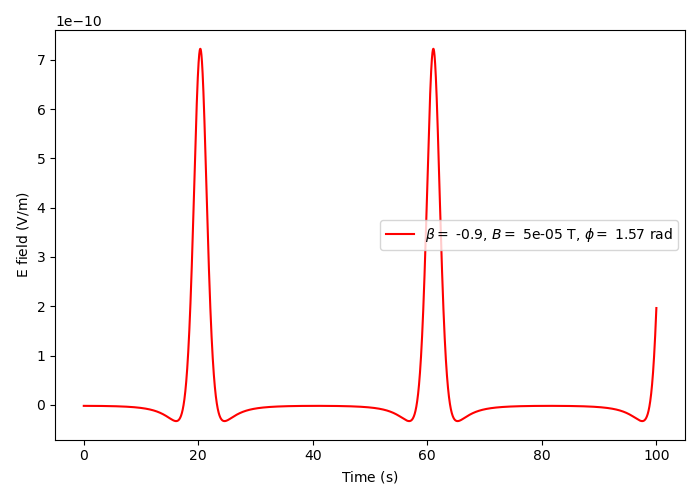

In [11]:
E_field = Edata(binsize=0.01, beta=-0.9, B_field=0.00005, pitch_angle=np.pi/2, time_duration=100)
# print(len(E_field.time_sec), E_field.time_sec, E_field.count_rate)

plot_Edata(E_field, show=True, newfig=True)

/var/folders/61/4drw60js54z076m981_6b9ch0000gn/T/ipykernel_13320/2267799428.py:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(left=0, right=1)


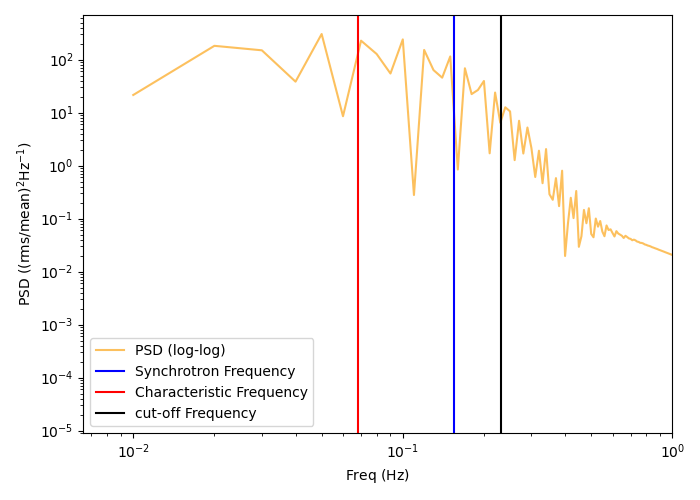

In [12]:
# E_field = Edata(binsize=0.01, beta=0.99, B_field=0.00005, pitch_angle=np.pi/2, time_duration=100)
PSD = PSDdata(E_field)

plot_PSD(PSD, show=True, newfig=True, color=(0.98826, 0.652325, 0.1, 0.7), labeltext='PSD (log-log)')

In [13]:
# E_field = Edata(binsize=0.01, beta=0.9, B_field=0.00005, pitch_angle=np.pi/2, time_duration=10000)

# list_Echunks = get_list_E(E_field, cut_time_duration=200)
# list_PSDchunks = get_list_PSD(list_Echunks)

# PSDavg = average_PSD(list_PSDchunks)
# plot_PSD(PSDavg, show=True, newfig=True, color='g', labeltext='Averaged PSD')